In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# imports for neural network
import tensorflow as tf
from tensorflow import keras
from keras_visualizer import visualizer  

c:\Users\Jörg\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Jörg\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Jörg\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# load Base.csv
df = pd.read_csv('Base.csv')
# remove "device_fraud_count"
df = df.drop(['device_fraud_count'], axis=1, errors='ignore') # It's 0 for all rows
# show only the correlation between the variables and the target
df.corr()['fraud_bool'].sort_values(ascending=False)

fraud_bool                          1.000000
credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
income                              0.045079
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
email_is_free                       0.027758
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
zip_count_4w                        0.005212
days_since_request                  0.000567
bank_months_count                  -0.003222
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
phone_mobile_valid                 -0.013180
velocity_6h                        -0.016892
intended_balcon_amount             -0.024524
prev_address_months_count          -0.026031
phone_home_valid                   -0.035128
has_other_

In [3]:
# count the number frauds and non-frauds
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [4]:
# # Keep all the frauds and equal number of non-frauds
# df_fraud = df[df['fraud_bool']==1]
# df_non_fraud = df[df['fraud_bool']==0].sample(n=len(df_fraud), random_state=42)
# df = pd.concat([df_fraud, df_non_fraud])

# # count the number frauds and non-frauds
# df['fraud_bool'].value_counts()

I thought it would be better to balance the number of frauds and non frauds but then I get only 0.8 accuraccy. If I leave this out, I get 0.99. Because of that, I assume this approach is wrong and that there is a definitive answer for every entry if it is fraud or not.

In [5]:
# create train and test data

X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# onehot encoding for categorical variables

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)


## Model Creation
### Baseline Models

In [7]:
# # create baseline models

# # create baseline model xgboost
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train, verbose=False)
# y_pred = xgb_model.predict(X_test)
# print(accuracy_score(y_test, y_pred))

# # create baseline model random forest
# rf_model = RandomForestClassifier()
# rf_model.fit(X_train, y_train)
# y_pred = rf_model.predict(X_test)
# print(accuracy_score(y_test, y_pred))

# # create baseline model logistic regression
# lr_model = LogisticRegression()
# lr_model.fit(X_train, y_train)
# y_pred = lr_model.predict(X_test)
# print(accuracy_score(y_test, y_pred))

### Some utility functions for testing keras models

In [8]:
def plot_history(history):
    plt.plot(history.history['binary_accuracy'], label='accuracy')
    plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [9]:
def train_eval_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )


    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )


    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=512,
        epochs=1000,
        callbacks=[early_stopping],
        verbose=1, # hide the output because we have so many epochs
    )
    
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_history(history)
    return accuracy_score(y_test, y_pred)


Epoch 1/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 4.1867 - binary_accuracy: 0.9801 - val_loss: 0.0658 - val_binary_accuracy: 0.9875
Epoch 2/1000
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1150 - binary_accuracy: 0.9869 - val_loss: 0.0561 - val_binary_accuracy: 0.9886
Epoch 3/1000
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1076 - binary_accuracy: 0.9870 - val_loss: 0.0987 - val_binary_accuracy: 0.9889
Epoch 4/1000
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0927 - binary_accuracy: 0.9875 - val_loss: 0.0492 - val_binary_accuracy: 0.9889
Epoch 5/1000
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1177 - binary_accuracy: 0.9868 - val_loss: 0.0516 - val_binary_accuracy: 0.9880
Epoch 6/1000
1563/1563 [==============================] - 2s 1ms/step - loss: 0.1350 - binary_accuracy: 0.9871 - val_loss: 0.0584 - val_binary_accuracy: 0.9889
Epoch 7/1000
1563/1563 [================

0.988865

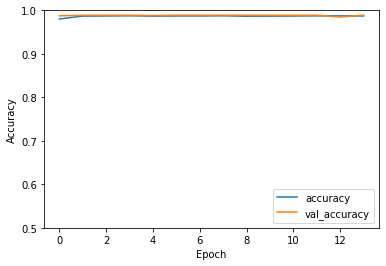

In [10]:
# create baseline model neural network
model = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=[X_train.shape[1]]),
])
train_eval_model(model)

In [11]:
visualizer(model, format='png',filename='model')

Epoch 1/1000
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1098 - binary_accuracy: 0.9665 - val_loss: 0.0527 - val_binary_accuracy: 0.9889
Epoch 2/1000
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0512 - binary_accuracy: 0.9888 - val_loss: 0.0499 - val_binary_accuracy: 0.9889
Epoch 3/1000
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0492 - binary_accuracy: 0.9889 - val_loss: 0.0488 - val_binary_accuracy: 0.9889
Epoch 4/1000
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0486 - binary_accuracy: 0.9889 - val_loss: 0.0483 - val_binary_accuracy: 0.9889
Epoch 5/1000
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0481 - binary_accuracy: 0.9889 - val_loss: 0.0479 - val_binary_accuracy: 0.9889
Epoch 6/1000
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0477 - binary_accuracy: 0.9889 - val_loss: 0.0477 - val_binary_accuracy: 0.9889
Epoch 7/1000
1563/1563 [================

0.98893

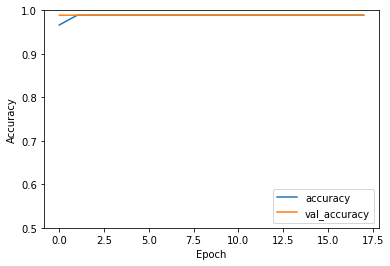

In [12]:
# Keras model using dropout and batch normalization
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
train_eval_model(model)

In [13]:
visualizer(model, format='png',filename='model')

ValueError: Keras Visualizer: Layer not supported for visualizing

# Notes/ Disclaimer
Through a better understanding of the data the score could be improved. Also there is presumably a high amount of dependent variables and bias in the data. 

After spending a bit more time on the problem, predicting the target seems to be super simple. After just 1 epoch on a single sigmoid-neuron, the accuracy is >.99.